### 1. Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

### 2. Load the datasets

In [3]:
TRADES_PATH = "csv_files/historical_data.csv"
SENTIMENT_PATH = "csv_files/fear_greed_index.csv"

df_trades = pd.read_csv(TRADES_PATH)
df_sent = pd.read_csv(SENTIMENT_PATH)

print(df_trades.shape)
print(df_sent.shape)

(211224, 16)
(2644, 4)


### 3. Clean Column Names

In [4]:
df_trades.columns = df_trades.columns.str.strip().str.lower().str.replace(" ", "_")
df_sent.columns = df_sent.columns.str.strip().str.lower().str.replace(" ", "_")


### 4. Parse Time + Numeric Safely

In [5]:
# --- trades time
time_cols = [c for c in df_trades.columns if "time" in c]
df_trades[time_cols[0]] = pd.to_datetime(df_trades[time_cols[0]], errors="coerce")

# --- sentiment date
df_sent["date"] = pd.to_datetime(df_sent["date"], errors="coerce")

# --- numeric conversion
for c in df_trades.columns:
    df_trades[c] = pd.to_numeric(df_trades[c], errors="ignore")


### 5. Feature Engineering

In [6]:
# --- detect columns
price_col = [c for c in df_trades.columns if "price" in c][0]
size_col = [c for c in df_trades.columns if "size" in c][0]
pnl_col = [c for c in df_trades.columns if "pnl" in c][0]

fee_cols = [c for c in df_trades.columns if "fee" in c]
time_col = time_cols[0]

# --- features
df_trades["notional_value"] = df_trades[price_col] * df_trades[size_col]
df_trades["total_fee"] = df_trades[fee_cols].sum(axis=1) if fee_cols else 0
df_trades["net_pnl"] = df_trades[pnl_col] - df_trades["total_fee"]
df_trades["pnl_pct"] = df_trades["net_pnl"] / df_trades["notional_value"].replace(0, np.nan)

df_trades["date"] = pd.to_datetime(df_trades[time_col], unit='ns').dt.date


### 6. Aggregate Trading Behaviour day by day

In [7]:
daily_metrics = df_trades.groupby("date").agg(
    total_volume=("notional_value","sum"),
    avg_trade_size=("notional_value","mean"),
    total_net_pnl=("net_pnl","sum"),
    avg_pnl=("net_pnl","mean"),
    pnl_std=("net_pnl","std"),
    trades_count=("net_pnl","count"),
    win_rate=("net_pnl", lambda x: (x>0).mean())
).reset_index()


### 7. Prepare Sentiment

In [8]:
df_sent["date"] = df_sent["date"].dt.date
df_sent["sentiment"] = df_sent["classification"].str.lower()

### 8. Merge Both Datasets

In [9]:
merged = pd.merge(daily_metrics, df_sent[["date","sentiment"]], on="date", how="inner")

print("Merged shape:", merged.shape)
merged.head()

Merged shape: (158, 9)


,date,total_volume,avg_trade_size,total_net_pnl,avg_pnl,pnl_std,trades_count,win_rate,sentiment
0,2023-01-05,476.992810,158.997603,0.000000,0.000000,0.000000,3,0.000000,fear
1,2023-05-12,50005.829170,5556.203241,-12.501455,-1.389051,1.921232,9,0.000000,neutral
2,2024-01-01,264239.512610,14679.972923,-195.591327,-10.866185,85.036680,18,0.055556,greed
3,2024-01-02,2008.184771,334.697462,-0.502044,-0.083674,0.032013,6,0.000000,greed
4,2024-01-03,472974.663145,3452.369804,8244.788263,60.180936,111.609815,137,1.000000,greed


### 9. Compare Fear vs Greed

In [10]:
sentiment_summary = merged.groupby("sentiment").agg(
    avg_volume=("total_volume","mean"),
    avg_trade_size=("avg_trade_size","mean"),
    avg_pnl=("avg_pnl","mean"),
    total_pnl=("total_net_pnl","sum"),
    avg_win_rate=("win_rate","mean"),
    avg_trades=("trades_count","mean")
).reset_index()

print(sentiment_summary)

       sentiment    avg_volume  avg_trade_size    avg_pnl     total_pnl  \
0   extreme fear  1.596707e+06     2191.148975   8.357697  2.803185e+03   
1  extreme greed  4.238084e+05     7954.335769  44.219741  1.152196e+06   
2           fear  2.153362e+06     6014.623687  54.180574  1.763533e+06   
3          greed  1.018675e+06     6352.086509  27.235929  5.972910e+05   
4        neutral  7.462219e+05     7191.752590  26.175113  7.211464e+04   

   avg_win_rate  avg_trades  
0      0.306165  387.666667  
1      0.340507  130.720930  
2      0.358535  374.837838  
3      0.386254  201.642857  
4      0.364915  172.250000  


### 10. Save merged Outputs

In [16]:
os.makedirs(f"csv_files", exist_ok=True)
os.makedirs(f"outputs", exist_ok=True)

merged.to_csv(f"csv_files/merged_sentiment_trades.csv", index=False)
sentiment_summary.to_csv(f"csv_files/sentiment_summary.csv", index=False)

### 11. Visuaization

##### 11.1 Volume by Sentiment

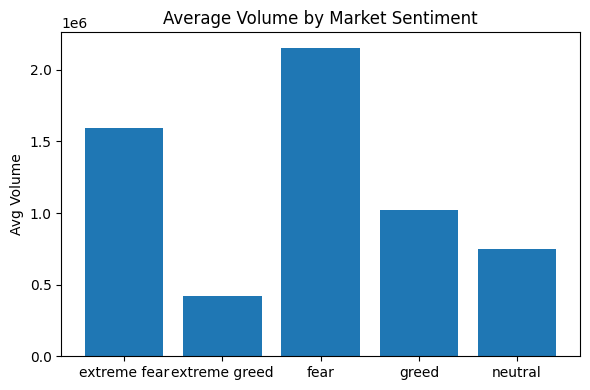

In [17]:
plt.figure(figsize=(6,4))
plt.bar(sentiment_summary["sentiment"], sentiment_summary["avg_volume"])
plt.title("Average Volume by Market Sentiment")
plt.ylabel("Avg Volume")
plt.tight_layout()
plt.savefig(f"outputs/avg_volume_by_sentiment.png")
plt.show()

##### 11.2 Profitability by Sentiment

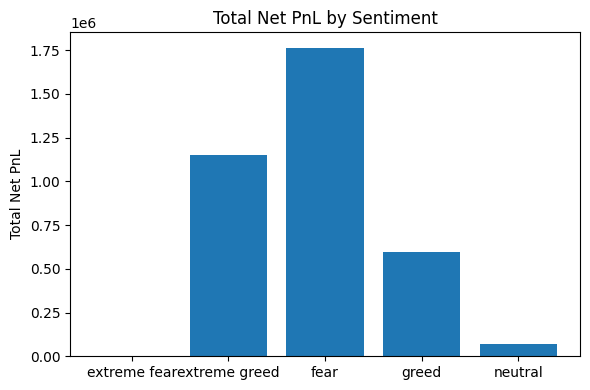

In [19]:
plt.figure(figsize=(6,4))
plt.bar(sentiment_summary["sentiment"], sentiment_summary["total_pnl"])
plt.title("Total Net PnL by Sentiment")
plt.ylabel("Total Net PnL")
plt.tight_layout()
plt.savefig(f"outputs/total_pnl_by_sentiment.png")
plt.show()

##### 11.3 Win Rate by Sentiment

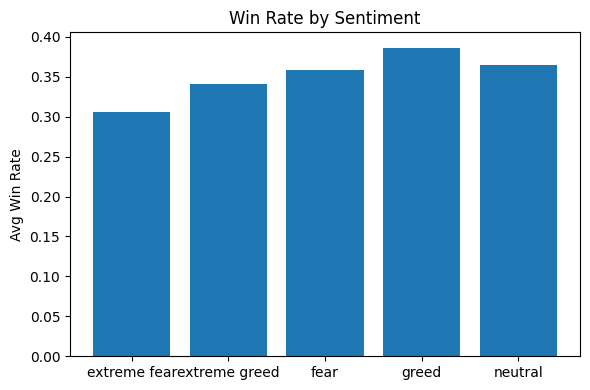

In [20]:
plt.figure(figsize=(6,4))
plt.bar(sentiment_summary["sentiment"], sentiment_summary["avg_win_rate"])
plt.title("Win Rate by Sentiment")
plt.ylabel("Avg Win Rate")
plt.tight_layout()
plt.savefig(f"outputs/winrate_by_sentiment.png")
plt.show()

##### 11.4 Trades Count by Sentiment

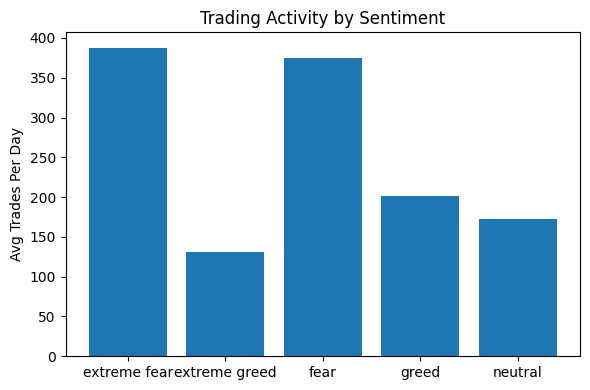

In [21]:
plt.figure(figsize=(6,4))
plt.bar(sentiment_summary["sentiment"], sentiment_summary["avg_trades"])
plt.title("Trading Activity by Sentiment")
plt.ylabel("Avg Trades Per Day")
plt.tight_layout()
plt.savefig(f"outputs/activity_by_sentiment.png")
plt.show()

##### 11.5 Risk vs Return by Sentiment

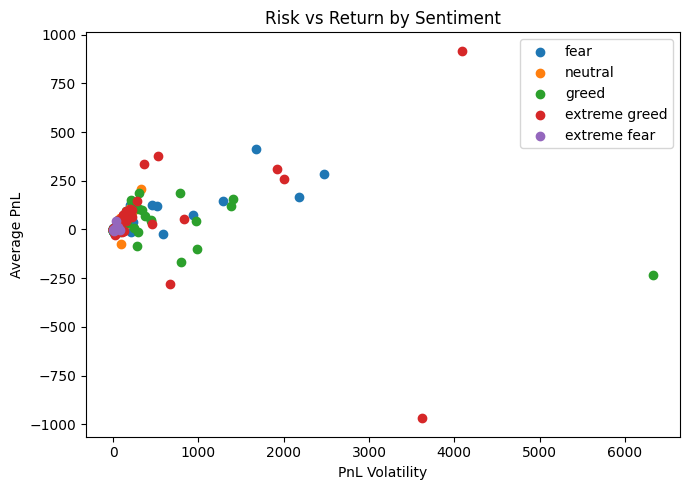

In [22]:
plt.figure(figsize=(7,5))

for s in merged["sentiment"].unique():
    sub = merged[merged["sentiment"]==s]
    plt.scatter(sub["pnl_std"], sub["avg_pnl"], label=s)

plt.xlabel("PnL Volatility")
plt.ylabel("Average PnL")
plt.title("Risk vs Return by Sentiment")
plt.legend()
plt.tight_layout()
plt.savefig(f"outputs/risk_return_by_sentiment.png")
plt.show()